<a href="https://colab.research.google.com/github/abkabd/TextSummarizer/blob/main/Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the *Kaggle API* in Colab

In [ ]:
!pip install kaggle

# Authenticating with Kaggle using kaggle.json

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


# Downloading a dataset

In [2]:
!kaggle datasets download 'phoenix120/gazeta-summaries'
# "vfomenko/russian-news-2020"

 98% 182M/185M [00:01<00:00, 96.8MB/s]
100% 185M/185M [00:02<00:00, 96.6MB/s]


In [3]:
!unzip gazeta-summaries.zip

Archive:  gazeta-summaries.zip
  inflating: gazeta_test.jsonl       
  inflating: gazeta_train.jsonl      
  inflating: gazeta_val.jsonl        


# Reading our dataset

In [4]:
import pandas as pd
path = '/content/gazeta_val.jsonl'
data = pd.read_json(path, lines=True)
# [['title', 'text']]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6369 entries, 0 to 6368
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     6369 non-null   datetime64[ns]
 1   url      6369 non-null   object        
 2   summary  6369 non-null   object        
 3   title    6369 non-null   object        
 4   text     6369 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 248.9+ KB


In [6]:
data.head()

,date,url,summary,title,text
0,2020-01-01 10:29:58,https://www.gazeta.ru/business/2019/12/26/1288...,В уходящем году инфляция в России находится на...,Дорогой 2020-й: какие продукты подскочат в цене,"В 2020 году инфляция в России составит 3,5-4%,..."
1,2020-01-01 11:16:44,https://www.gazeta.ru/army/2020/01/01/12894224...,Мировая общественность призвала лидера КНДР Ки...,Подарок от Ким Чен Ына: Трамп ответил на новые...,Глава Белого дома Дональд Трамп выразил надежд...
2,2020-01-01 12:39:08,https://www.gazeta.ru/politics/2020/01/01_a_12...,Главный раввин Польши Михаил Шудрих раскритико...,Это манипуляция: раввин Польши ответил Путину ...,Председатель Союза еврейских религиозных общин...
3,2020-01-01 13:36:41,https://www.gazeta.ru/culture/2020/01/01/a_128...,Народная артистка СССР София Ротару выступила ...,Первая после Путина: Ротару выступила на Новый...,Первой песней наступившего 2020 года на Первом...
4,2020-01-01 14:20:16,https://www.gazeta.ru/politics/2019/12/30_a_12...,1 января 1895 года родился самый могущественны...,"Пресли, Леннон, Трумэн: против кого работал Эд...","Выражение «глубинное государство», пришедшее и..."


In [7]:
data.shape

(6369, 5)

In [8]:
data.drop_duplicates(subset=['text'],inplace=True) #dropping duplicates
data.dropna(axis=0,inplace=True) #dropping na

In [9]:
df = data[['title', 'text', 'summary']]
df.head()

,title,text,summary
0,Дорогой 2020-й: какие продукты подскочат в цене,"В 2020 году инфляция в России составит 3,5-4%,...",В уходящем году инфляция в России находится на...
1,Подарок от Ким Чен Ына: Трамп ответил на новые...,Глава Белого дома Дональд Трамп выразил надежд...,Мировая общественность призвала лидера КНДР Ки...
2,Это манипуляция: раввин Польши ответил Путину ...,Председатель Союза еврейских религиозных общин...,Главный раввин Польши Михаил Шудрих раскритико...
3,Первая после Путина: Ротару выступила на Новый...,Первой песней наступившего 2020 года на Первом...,Народная артистка СССР София Ротару выступила ...
4,"Пресли, Леннон, Трумэн: против кого работал Эд...","Выражение «глубинное государство», пришедшее и...",1 января 1895 года родился самый могущественны...


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6369 entries, 0 to 6368
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     6369 non-null   datetime64[ns]
 1   url      6369 non-null   object        
 2   summary  6369 non-null   object        
 3   title    6369 non-null   object        
 4   text     6369 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 298.5+ KB


# Text preprocessing

In [11]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 8.7 MB/s 


In [12]:
import numpy as np
import pandas as pd 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import pymorphy2
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [13]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

In [15]:
def sentence_split(text):
  # sentences = re.split(r'[.?!]\s+', text)
  article = text.split(". ")
  sentences = []
  for sentence in article:
    # print(sentence)
    sentences.append(sentence.replace("[^а-яА-Я]", " ").split(" "))
    # sentences.pop() 

  return sentences

In [16]:
def text_cleaner(text):

  newString = text

  newString = text.lower()
  
  newString = re.sub(r'\([^)]*\)', '', newString)
  
  newString = re.sub('"','', newString)
  
  newString = re.sub(r"'s\b","",newString)
  
  newString = re.sub("[^а-яА-Я]", " ", newString)
  
  newString = re.sub('[m]{2,}', 'mm', newString)
  
  tokens = [w for w in newString.split() if not w in stop_words]

  long_words=[]
  for i in tokens:
      if len(i)>1:
          long_words.append(morph.parse(i)[0].normal_form)   
  # return (" ".join(long_words)).strip()
  return long_words

In [17]:
def generate_summarization(idx):

  text = df.text.iloc[idx]

  words = text_cleaner(text)
  freqTable = dict()

  for w in words:
    if w in stop_words:
      continue
    if w in freqTable:
      freqTable[w] += 1
    else:
      freqTable[w] = 1

  # print(freqTable)

  # sentences = sentence_split(text)
  sentences = sent_tokenize(text, language='russian')
  # print(sentences)
  sentenceValue = dict()

  for sent in sentences:
    for w, f in freqTable.items():
      if w in sent.lower():
        if sent in sentenceValue:
          sentenceValue[sent] += f
        else:
          sentenceValue[sent] = f

  sum = 0
  for s in sentenceValue:
    sum += sentenceValue[s]
  avg = int(sum/len(sentenceValue))
  coeff = 2

  summary = ""
  for s in sentences:
    if(s in sentenceValue) and (sentenceValue[s] > (coeff*avg)):
      summary += s+" "

  return summary

In [18]:
def get_jaccard_sim(str1, str2):
  arr1 = text_cleaner(str1)
  arr2 = text_cleaner(str2)
  a = set(arr1) 
  b = set(arr2)
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [19]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [20]:
generate_summarization(0)

'В 2019 году стоимость молока-сырья выросла на 9% и, как следствие, увеличилась цена на готовую продукцию: питьевое молоко за год подорожало на 7%, кефир, ряженка, творог — на 6 %, йогурт – на 8%, сметана на 7%, мороженое на 9%, полутвердые сыры на 10%, сливочное масло – на 11%, рассказала «Газете.Ru» заместитель председателя комитета МТПП по развитию предпринимательства в АПК, генеральный директор «Petrova 5 Consulting» Марина Петрова. По его словам, в 2020 году возрастает и ставка акциза, и цена спирта, а также накладные расходы производителей. Позитивную динамику ценам на продукты помимо фруктов и овощей в прошлом году обеспечило и снижение цен на сахар (почти на 30% с января по ноябрь), яйца (10%), куриное мясо (4,5%) и свинину (3,5%). Теплая погода в России поддерживает рост озимых и не позволяет внутренним ценам расти вслед за экспортными. '

In [51]:
df.summary.iloc[0]

'В уходящем году инфляция в России находится на историческом минимуме. В следующем году ожидается, что она также будет минимальной. Однако стоимость ряда продуктов и напитков в 2020 году может вырасти гораздо выше инфляции. Это касается молочных продуктов. Вырастет в цене водка, коньяк и вино, продолжит дорожать гречка.'

In [47]:
test_num = 1500
jaccard_similarity_array = []
cosine_similarity_array = []
for i in range(test_num):
  s1 = generate_summarization(i)
  s2 = df.summary.iloc[i]
  res = get_jaccard_sim(s1, s2)
  if res > 0.3:
    jaccard_similarity_array.append(res)

In [48]:
jaccard_similarity_array

[0.3157894736842105,
 0.36231884057971014,
 0.38461538461538464,
 0.43243243243243246,
 0.3103448275862069,
 0.39344262295081966,
 0.40540540540540543,
 0.5945945945945946,
 0.3170731707317073,
 0.43137254901960786,
 0.3673469387755102,
 0.3220338983050847,
 0.3125,
 0.3448275862068966,
 0.30158730158730157,
 0.3404255319148936,
 0.30434782608695654,
 0.4634146341463415,
 0.40816326530612246,
 0.35714285714285715,
 0.3090909090909091,
 0.37735849056603776,
 0.34375,
 0.3611111111111111,
 0.3939393939393939,
 0.32142857142857145,
 0.35714285714285715,
 0.352112676056338,
 0.3055555555555556,
 0.3958333333333333,
 0.41025641025641024,
 0.36538461538461536,
 0.3076923076923077,
 0.32,
 0.425,
 0.4722222222222222,
 0.3225806451612903,
 0.3698630136986301,
 0.3493975903614458,
 0.36065573770491804,
 0.40816326530612246,
 0.3230769230769231,
 0.375,
 0.3877551020408163,
 0.3333333333333333,
 0.38235294117647056,
 0.39344262295081966,
 0.32653061224489793,
 0.34210526315789475,
 0.36923076923

In [49]:
rs = jaccard_similarity_array[::-1]
print(rs)

[0.3181818181818182, 0.391304347826087, 0.3275862068965517, 0.3333333333333333, 0.32967032967032966, 0.33707865168539325, 0.34210526315789475, 0.3404255319148936, 0.3333333333333333, 0.34146341463414637, 0.4117647058823529, 0.391304347826087, 0.32558139534883723, 0.3058823529411765, 0.3269230769230769, 0.3023255813953488, 0.3220338983050847, 0.30357142857142855, 0.3793103448275862, 0.3673469387755102, 0.3333333333333333, 0.325, 0.3424657534246575, 0.425, 0.34375, 0.30303030303030304, 0.36923076923076925, 0.34210526315789475, 0.32653061224489793, 0.39344262295081966, 0.38235294117647056, 0.3333333333333333, 0.3877551020408163, 0.375, 0.3230769230769231, 0.40816326530612246, 0.36065573770491804, 0.3493975903614458, 0.3698630136986301, 0.3225806451612903, 0.4722222222222222, 0.425, 0.32, 0.3076923076923077, 0.36538461538461536, 0.41025641025641024, 0.3958333333333333, 0.3055555555555556, 0.352112676056338, 0.35714285714285715, 0.32142857142857145, 0.3939393939393939, 0.3611111111111111, 0

[0.3181818181818182, 0.391304347826087, 0.3275862068965517, 0.3333333333333333, 0.32967032967032966, 0.33707865168539325, 0.34210526315789475, 0.3404255319148936, 0.3333333333333333, 0.34146341463414637, 0.4117647058823529, 0.391304347826087, 0.32558139534883723, 0.3058823529411765, 0.3269230769230769, 0.3023255813953488, 0.3220338983050847, 0.30357142857142855, 0.3793103448275862, 0.3673469387755102, 0.3333333333333333, 0.325, 0.3424657534246575, 0.425, 0.34375, 0.30303030303030304, 0.36923076923076925, 0.34210526315789475, 0.32653061224489793, 0.39344262295081966, 0.38235294117647056, 0.3333333333333333, 0.3877551020408163, 0.375, 0.3230769230769231, 0.40816326530612246, 0.36065573770491804, 0.3493975903614458, 0.3698630136986301, 0.3225806451612903, 0.4722222222222222, 0.425, 0.32, 0.3076923076923077, 0.36538461538461536, 0.41025641025641024, 0.3958333333333333, 0.3055555555555556, 0.352112676056338, 0.35714285714285715, 0.32142857142857145, 0.3939393939393939, 0.3611111111111111, 0

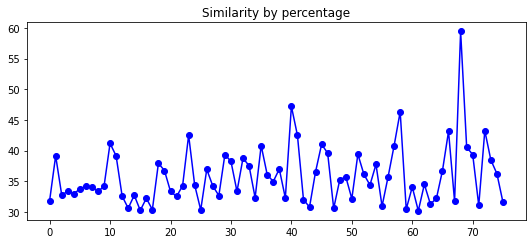

In [50]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

rs = jaccard_similarity_array.reverse()
x = np.array([i for i in range(len(jaccard_similarity_array))])

print(jaccard_similarity_array)
y1 = np.array(jaccard_similarity_array)*100
plt.title("Similarity by percentage")
plt.plot(color='red')
plt.plot(x, y1, "-ok", color='blue')

plt.show()